## SVG repr

Let's add a little class to make producing XML (and therefor SVG) easy. Note that this originally targeted boost-histogram, so it's written in Python 2 compatible style and does not use any external libraries.

In [1]:
class XML(object):
    def __init__(self, *contents, **kargs):
        self.properties = kargs
        self.contents = contents

    @property
    def name(self):
        return self.__class__.__name__

    @property
    def start(self):
        if self.properties:
            ending = " " + " ".join(
                '{a}="{b}"'.format(a=a.replace("_", "-"), b=b)
                for a, b in self.properties.items()
            )
        else:
            ending = ""
        return self.name + ending

    def __str__(self):
        if self.contents:
            return "<{self.start}>\n{contents}\n</{self.name}>".format(
                self=self, contents="\n".join(str(s) for s in self.contents)
            )
        else:
            return "<{self.start}/>".format(self=self)

Now let's add classes that exactly correspond to the `XML` tags:

In [2]:
class svg(XML):
    def _repr_svg_(self):
        return str(self)


class circle(XML):
    pass


class line(XML):
    pass


class rect(XML):
    pass


class ellipse(XML):
    pass


class polygon(XML):
    pass


class polyline(XML):
    pass


# path
class text(XML):
    pass


class g(XML):
    pass

Now let's make sure these work as expected:

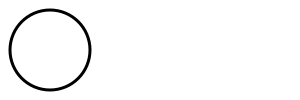

In [3]:
c1 = circle(cx=50, cy=50, r=40, stroke="black", stroke_width=3, fill="white")
s1 = svg(c1, height=100, width=300)
s1

In [4]:
print(s1)

<svg height="100" width="300">
<circle cx="50" cy="50" r="40" stroke="black" stroke-width="3" fill="white"/>
</svg>


## Work with histogram

In [5]:
import textwrap
import numpy as np
import boost_histogram as bh
import functools
import operator
import math
import hist

In [6]:
class Histogram(hist.Hist):
    def _repr_svg_(self):
        # This can be _repr_html_ instead, too - would make adding text easier/nicer
        if self.ndim == 1:
            if not self.axes[0].options.circular:
                return plot_hist_1d(self)._repr_svg_()
            else:
                return plot_hist_1d_c(self)._repr_svg_()
        elif self.ndim == 2:
            return plot_hist_2d(self)._repr_svg_()
        else:
            return plot_hist_md(self)._repr_svg_()

Now let's make a svg plotting function:

This automatically but poorly scales if the axes is more than 40 bins wide. The issue is that it simply rebins, rather than making uneven width bins when necessary.

In [7]:
class rect(XML):
    @classmethod
    def pad(
        cls,
        x,
        y,
        scale_x,
        scale_y,
        height,
        left_edge,
        right_edge,
        pad_x=0,
        pad_y=0,
        opacity=1,
        stroke_width=2,
    ):
        width = right_edge - left_edge
        center_y = height / 2.0
        top_y = y

        height = height * (1 - 2 * pad_y)
        top_y = top_y * (1 - 2 * pad_y) + pad_y
        left_edge = left_edge * (1 - 2 * pad_x) + pad_x
        width = width * (1 - 2 * pad_x)
        color = int(opacity * 255)

        return cls(
            x=x * scale_x,
            y=top_y * scale_y,
            width=width * scale_x,
            height=height * scale_y,
            style=f"fill:rgb({color}, {color}, {color});stroke:rgb(0,0,0);stroke-width:{stroke_width}",
        )

In [8]:
def plot_hist_1d(hi):
    assert hi.ndim == 1
    assert not hi.axes[0].options.circular

    if len(hi.axes[0]) > 40:
        h = hi[:: bh.rebin(len(hi.axes[0]) // 20)]
    else:
        h = hi

    (edges,) = h.axes.edges
    norm_edges = (edges - edges[0]) / (edges[-1] - edges[0])
    norm_vals = h.view()

    if not h.empty():
        norm_vals /= functools.reduce(operator.mul, h.axes.widths) / h.sum()
        norm_vals /= np.max(norm_vals)

    boxes = []
    for height, left_edge, right_edge in zip(
        norm_vals, norm_edges[:-1], norm_edges[1:]
    ):
        boxes.append(
            rect.pad(
                left_edge,
                1 - height,
                300,
                100,
                height,
                left_edge,
                right_edge,
                0.02,
                0.05,
            )
        )

    # boxes.append(rect(x=0, y=0, width=600, height=120, style="fill:none;stroke-width:3;stroke:rgb(0,0,0)"))
    ax_line = line(
        x1=0,
        y1=100 * 0.95,
        x2=300,
        y2=100 * 0.95,
        style="fill:none;stroke-width:2;stroke:rgb(0,0,0)",
    )
    texts = [
        text(format(edges[0], ".3g"), x=10, y=110),
        text(format(edges[-1], ".3g"), x=300 - 20, y=110),
        text(
            "\n".join(textwrap.wrap(repr(hi), width=30, max_lines=2)),
            x=320,
            y=40,
            style="font-family: monospace",
        ),
        text(
            "\n".join(
                textwrap.wrap(
                    str(hi.axes[0].name or hi.axes[0].label), width=30, max_lines=2
                )
            ),
            x=140,
            y=120,
            style="font-family: monospace",
        ),
    ]

    return svg(ax_line, *texts, *boxes, width=800, height=160)

And let's add it inline. (In an actual library, this should just have been a method, really)

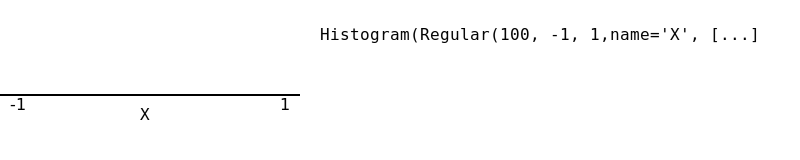

In [9]:
h = Histogram(hist.axis.Regular(100, -1, 1, name="X", label="label"))
h

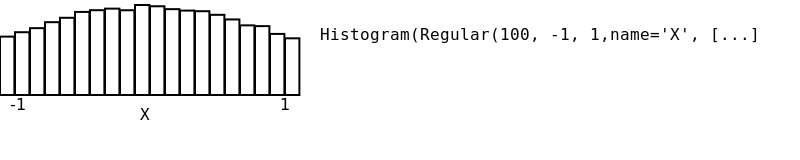

In [10]:
h.fill(np.random.normal(size=100_000))
h

In [11]:
def plot_hist_2d(hi):
    assert hi.ndim == 2

    if len(hi.axes[0]) > 40:
        hi = hi[:: bh.rebin(len(hi.axes[0]) // 20), :]

    if len(hi.axes[1]) > 40:
        hi = hi[:, :: bh.rebin(len(hi.axes[1]) // 20)]

    h = hi

    edges = (h.axes[0].edges, h.axes[1].edges)
    norm_edges = (
        (edges[0] - edges[0][0]) / (edges[0][-1] - edges[0][0]),
        (edges[1] - edges[1][0]) / (edges[1][-1] - edges[1][0]),
    )

    norm_vals = h.view()
    if not h.empty():
        norm_vals /= functools.reduce(operator.mul, h.axes.widths) / h.sum()
        norm_vals /= np.max(norm_vals)

    boxes = []
    for r, up_edge, bottom_edge in zip(
        range(len(norm_edges[1])), norm_edges[1][:-1], norm_edges[1][1:]
    ):
        for c, left_edge, right_edge in zip(
            range(len(norm_edges[0])), norm_edges[0][:-1], norm_edges[0][1:]
        ):
            opacity = 1 - norm_vals[r][c]
            boxes.append(
                rect.pad(
                    left_edge,
                    up_edge,
                    200,
                    200,
                    bottom_edge - up_edge,
                    left_edge,
                    right_edge,
                    0.05,
                    0.05,
                    opacity=opacity,
                    stroke_width=1,
                )
            )

    texts = [
        text(format(edges[0][0], ".3g"), x=0, y=210),
        text(format(edges[0][-1], ".3g"), x=190, y=210),
        text(format(edges[1][0], ".3g"), x=210, y=15),
        text(format(edges[1][-1], ".3g"), x=210, y=200),
        text(
            "\n".join(textwrap.wrap(repr(hi), width=30, max_lines=2)),
            x=240,
            y=40,
            style="font-family: monospace",
        ),
        text(
            "\n".join(
                textwrap.wrap(
                    str(hi.axes[0].name or hi.axes[0].label), width=30, max_lines=2
                )
            ),
            x=90,
            y=210,
            style="font-family: monospace",
        ),
        text(
            "\n".join(
                textwrap.wrap(
                    str(hi.axes[1].name or hi.axes[1].label), width=30, max_lines=2
                )
            ),
            x=210,
            y=100,
            style="font-family: monospace",
        ),
    ]

    return svg(*texts, *boxes, width=800, height=250)

In [12]:
h = (
    Histogram
    .new
    .Reg(100, -3, 3, name="X", label="x-label")
    .Reg(100, -3, 3, name="Y", label="y-label")
    .Double()
)

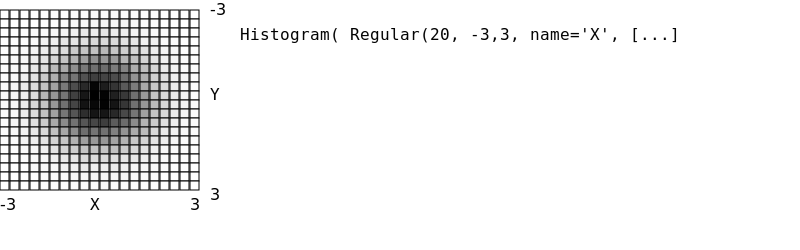

In [13]:
h.fill(np.random.normal(size=100_000), np.random.normal(size=100_000))
h

In [14]:
def plot_hist_md(hi):
    assert hi.ndim > 2

    h = hi

    boxes = []
    for i in range(3):
        boxes.append(
            boxes.append(
                rect(
                    x=20 + 20 * i,
                    y=20 + 20 * i,
                    width=120,
                    height=120,
                    style="fill:white;stroke-width:3;stroke:rgb(0,0,0)",
                )
            )
        )

    polylines = [
        polyline(
            points=""
            + f"{3*20}, {3*20+105} "
            + f"{3*20+30}, {3*20+105} "
            + f"{3*20+30}, {3*20+95} "
            + f"{3*20+40}, {3*20+95} "
            + f"{3*20+40}, {3*20+70} "
            + f"{3*20+50}, {3*20+70} "
            + f"{3*20+50}, {3*20+52} "
            + f"{3*20+60}, {3*20+52} "
            + f"{3*20+60}, {3*20+45} "
            + f"{3*20+70}, {3*20+45} "
            + f"{3*20+70}, {3*20+65} "
            + f"{3*20+80}, {3*20+65} "
            + f"{3*20+80}, {3*20+95} "
            + f"{3*20+90}, {3*20+95} "
            + f"{3*20+90}, {3*20+105} "
            + f"{3*20+120}, {3*20+105} ",
            style="fill:none;stroke:black;stroke-width:2",
        ),
    ]

    names = ""
    for i in range(hi.ndim):
        names += str(hi.axes[i].name or hi.axes[i].label)
        names += ", " if i + 1 - h.ndim else ". "

    texts = [
        text(
            "\n".join(textwrap.wrap(f"{h.ndim}-D", width=30, max_lines=2)),
            x=3 * 20 + 45,
            y=3 * 20 + 30,
            style="font-size: 18;font-family: verdana;font-style: bold;",
        ),
        text(
            "\n".join(textwrap.wrap(repr(hi), width=30, max_lines=2)),
            x=220,
            y=40,
            style="font-family: monospace",
        ),
        text(
            "\n".join(textwrap.wrap(names, width=30, max_lines=2)),
            x=80,
            y=200,
            style="font-family: monospace",
        ),
    ]

    return svg(*boxes, *texts, *polylines, width=800, height=220)

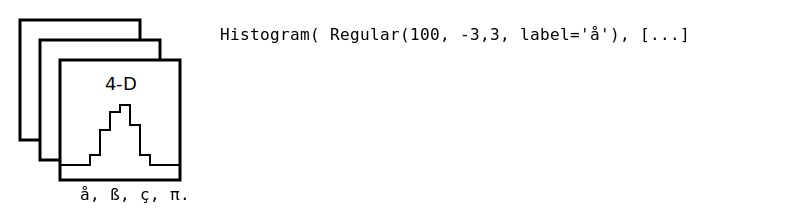

In [15]:
h = (
    Histogram
    .new
    .Reg(100, -3, 3, name="", label="å")
    .Reg(100, -3, 3, name="", label="ß")
    .Reg(100, -3, 3, name="", label="ç")
    .Reg(100, -3, 3, name="", label="π")
    .Int64()
) 
h # could be dangerous and slow for hist-5d+

In [16]:
def plot_hist_1d_c(hi):
    assert hi.ndim == 1
    assert hi.axes[0].options.circular

    if len(hi.axes[0]) > 40:
        h = hi[:: bh.rebin(len(hi.axes[0]) // 20)]
    else:
        h = hi

    (edges,) = h.axes.edges
    norm_edges = (edges - edges[0]) / (edges[-1] - edges[0])
    norm_vals = h.view()

    if not h.empty():
        norm_vals /= functools.reduce(operator.mul, h.axes.widths) / h.sum()
        norm_vals /= np.max(norm_vals)

    polygons = []
    ang = math.pi * 2 / (len(edges) - 1)
    for i in range(len(edges) - 1):
        polygons.append(
            polygon(
                points=""
                + "150, 125 "
                + f"{150+100*norm_vals[i] * math.cos(i * ang)}, {125+100*norm_vals[i] * math.sin(i * ang)} "
                + f"{150+100*norm_vals[i] * math.cos((i+1) * ang)}, {125+100*norm_vals[i] * math.sin((i+1) * ang)} ",
                style="fill:none;stroke:black;stroke-width:2",
            )
        )

    circles = [
        circle(
            cx="150",
            cy="125",
            r=f"{30*min(norm_vals)}",
            stroke="black",
            fill="white",
            stroke_width="3",
        )
    ]

    texts = [
        text(format(edges[0], ".3g"), x=170 + 100 * norm_vals[0], y=130),
        text(
            "\n".join(textwrap.wrap(repr(hi), width=30, max_lines=2)),
            x=320,
            y=40,
            style="font-family: monospace",
        ),
        text(
            "\n".join(
                textwrap.wrap(
                    str(hi.axes[0].name or hi.axes[0].label), width=30, max_lines=2
                )
            ),
            x=140,
            y=125 + 100 * max(norm_vals),
            style="font-family: monospace",
        ),
    ]

    return svg(*polygons, *texts, *circles, width=800, height=250)
    pass

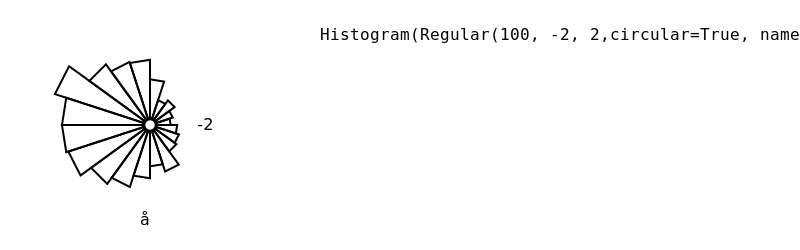

In [17]:
h = Histogram.new.Reg(100, -2, 2, name="å", label="å-label", circular=True).Double()
h.fill(np.random.normal(size=1_000))
h

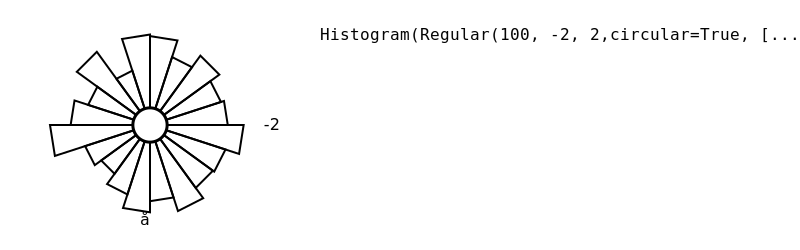

In [18]:
h = Histogram.new.Reg(100, -2, 2, name="", label="å", circular=True).Double()
h.fill(-2 + 4 * np.random.random(size=1_000))
h